In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

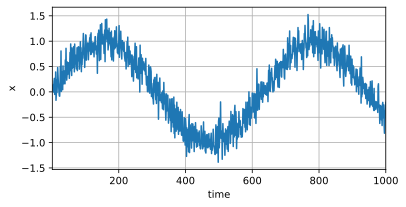

In [8]:
T  = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T, ))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [9]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

In [11]:
batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

In [12]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)


def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

loss = nn.MSELoss(reduction='none')

In [17]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, loss {d2l.evaluate_loss(net, train_iter, loss):.5f}')

In [53]:
net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss 0.06266
epoch 2, loss 0.05390
epoch 3, loss 0.05357
epoch 4, loss 0.05163
epoch 5, loss 0.05099


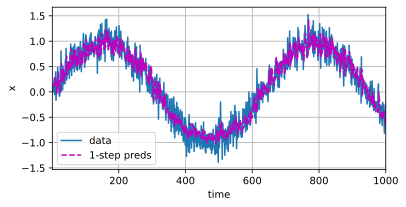

In [56]:
# 通过前四个预测当时前值
onestep_preds = net(features)
d2l.plot(
    [time, time[tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy()],
    xlabel='time', ylabel='x',
    legend=['data', '1-step preds'],
    xlim=[1, 1000], figsize=(6, 3)
)

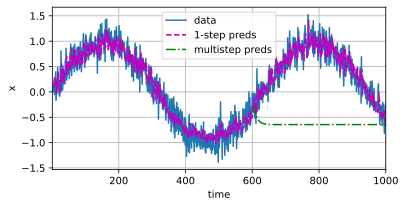

In [58]:
# 如果预测到604后边的数不知道的话， 将预测到的605加入其中继续预测， 效果并不理想
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot(
    [time, time[tau:], time[n_train + tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy(), multistep_preds[n_train + tau:].detach().numpy()],
    xlabel='time', ylabel='x',
    legend=['data', '1-step preds', 'multistep preds'],
    xlim=[1, 1000], figsize=(6, 3)
)

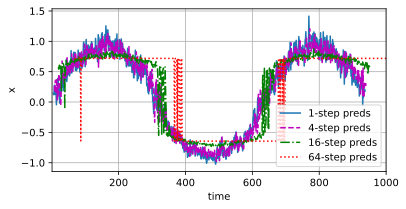

In [59]:
max_steps = 64
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))

for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau: i]).reshape(-1)

steps = [1, 4, 16, 64]
d2l.plot(
    [time[tau + step - 1: T - max_steps + step] for step in steps],
    [features[:, tau + step - 1].detach().numpy() for step in steps],
    xlabel='time', ylabel='x',
    legend=[f'{step}-step preds' for step in steps],
    xlim=[1, 1000], figsize=(6, 3)
)

<img src = "./pic/kstepspreds.jpg" />